In [2]:
'''

Hier werden die vorverarbeiteten Beschwerde-Texte in numerische Vektoren umgewandelt.
Dazu nutzen wir:
# 1. TF-IDF: Gewichtung relevanter Begriffe basierend auf Häufigkeit und Seltenheit
# 2. Word2Vec: Erzeugung semantisch reicher Worteinbettungen

Die Ergebnisse werden wieder gespeichert um mit dem nächsten Notebook die Themen zu Extrahieren und Analysieren

'''

import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib  # Sichere Alternative zu pickle für das Speichern von Modellen
import json    # Zum Speichern von Metadaten

In [3]:
# Versuchen Daten einzulesen
try:
    processed_df = pd.read_csv('../data/processed_complaints_v2.csv')
    print("Datei gefunden.")
    print(f"Geladene Texte: {len(processed_df)}")
except FileNotFoundError:
    print("Fehler: Datei 'processed_complaints_v2.csv' nicht gefunden. Zuerst 1. Datenvorverarbeitung ausführen")

Datei gefunden.
Geladene Texte: 66806


In [4]:
# Korpus erstellen, NaN-Werte entfernen sowie Numpy Array zu Listen konvertieren
corpus = processed_df['processed_text'].dropna().tolist()

In [5]:
##########################################################
# 1. TF-IDF Vektorisierung
##########################################################
tfidf_vectorizer = TfidfVectorizer(
    max_features = 2000, # die 2000 Häufigsten Themen | Vielleicht höher stellen oder niedriger stellen
    min_df = 5,          # Begriffe müssen in mindestens 5 Dokumenten vorkommen
    max_df= 0.75,        # Begriffe, die mehr als 85% der Dokumente vorkommen
    ngram_range=(1, 2)   # Berücksichtigt Unigramme und Bigramme (not good statt good)
)


In [6]:
# Vektorisierung durchführen
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
print(f"TF-IDF-Matrix erstellt mit Shape: {tfidf_matrix.shape}")
print("Beispielbegriffe:", list(tfidf_vectorizer.get_feature_names_out()[:10]))

TF-IDF-Matrix erstellt mit Shape: (66804, 2000)
Beispielbegriffe: ['ability', 'able', 'able get', 'able pay', 'absolutely', 'abuse', 'abusive', 'accept', 'acceptance', 'accepted']


In [7]:
# Speichern des TF-IDF Modells
joblib.dump(tfidf_vectorizer, '../models/tfidf_vectorizer.joblib')
np.save('../models/tfidf_matrix.npy', tfidf_matrix.toarray())

# Hier kam es zu einem Fehler mit einem Datentyp int64 um das Vokabular als JSON zu speichern. 
# Deshalb wird der Datentyp hier noch geändert. 

vocabulary_clean = {k: int(v) for k, v in tfidf_vectorizer.vocabulary_.items()}

# Speichern des Vokabulars als JSON für bessere Interpretierbarkeit
vocabulary = tfidf_vectorizer.vocabulary_
with open('../models/tfidf_vocabulary.json', 'w', encoding='utf-8') as f:
    json.dump(vocabulary_clean, f, ensure_ascii=False, indent=4)

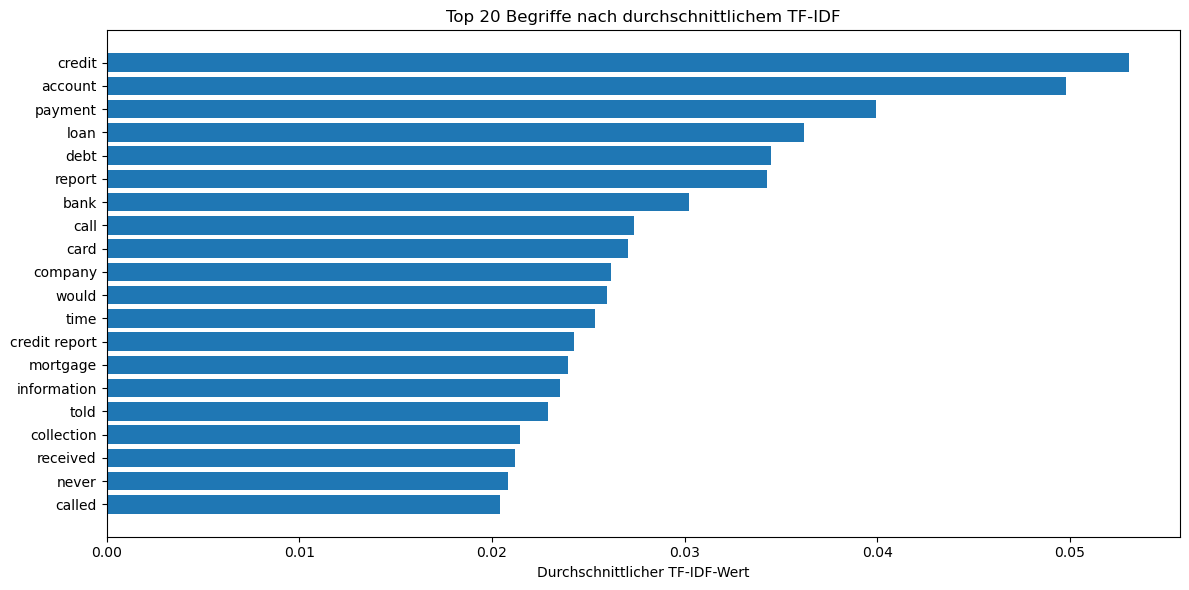

In [8]:
# Mittelwert je Spalte (= Begriff) berechnen
tfidf_means = np.asarray(tfidf_matrix.mean(axis=0)).flatten()

# Begriffe holen
terms = tfidf_vectorizer.get_feature_names_out()

# Top 20 Begriffe mit höchstem durchschnittlichen TF-IDF-Wert
top_n = 20
top_indices = tfidf_means.argsort()[::-1][:top_n]
top_terms = [terms[i] for i in top_indices]
top_scores = [tfidf_means[i] for i in top_indices]

# Balkendiagramm erstellen
plt.figure(figsize=(12, 6))
plt.barh(top_terms[::-1], top_scores[::-1])  # Ohne [::-1] sind die niedrigsten Werte oben
plt.xlabel("Durchschnittlicher TF-IDF-Wert")
plt.title("Top 20 Begriffe nach durchschnittlichem TF-IDF")
plt.tight_layout()
plt.show()

In [9]:
##########################################################
# 2. Bag-of-Words Vektorisierung für LDA
##########################################################

# CountVectorizer für Bag-of-Words erstellen
count_vectorizer = CountVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.75,
    ngram_range=(1, 2)
)

# Count Matrix berechnen
count_matrix = count_vectorizer.fit_transform(corpus)
print(f"Count Matrix erstellt: {count_matrix.shape[0]} Dokumente/Zeilen, {count_matrix.shape[1]} Features")

Count Matrix erstellt: 66804 Dokumente/Zeilen, 5000 Features


In [10]:
# Speichern des Count Vectorizers und der Matrix für die LDA-Analyse
joblib.dump(count_vectorizer, '../models/count_vectorizer_for_lda.joblib')
np.save('../models/count_matrix_for_lda.npy', count_matrix.toarray())

In [11]:
# Speichern des Vokabulars (für die Interpretation der LDA-Themen)
count_vocabulary = count_vectorizer.vocabulary_

# Konvertiere alle numpy.int64-Werte zu normalen Python int, auch hier kam es zu einem Datentyp Fehler
count_vocabulary = {key: int(value) for key, value in count_vocabulary.items()}

# Speichern des Vokabulars als JSON
with open('../models/count_vocabulary.json', 'w', encoding='utf-8') as f:
    json.dump(count_vocabulary, f, ensure_ascii=False, indent=4)


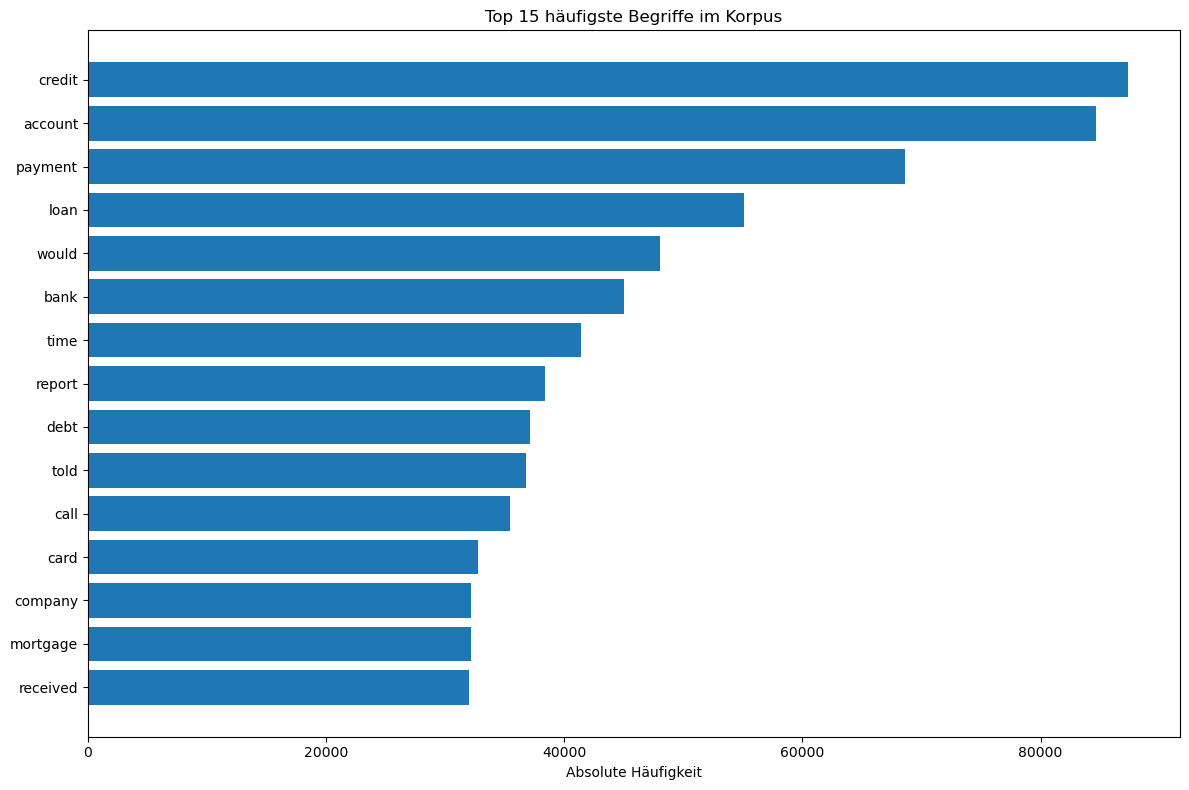

In [12]:
# Visualisierung der häufigsten Terme 
term_freq = np.sum(count_matrix.toarray(), axis=0)
count_terms = count_vectorizer.get_feature_names_out()

# Sortiere nach Häufigkeit und zeige die Top 15 Begriffe
term_freq_sorted = sorted(zip(count_terms, term_freq), key=lambda x: x[1], reverse=True)
top_terms = term_freq_sorted[:15][::-1] # Top 15 Begriffe umgekehrt sortiert

# Daten für das Balkendiagramm vorbereiten
plt.figure(figsize=(12, 8))
plt.barh([term[0] for term in top_terms], [term[1] for term in top_terms])
plt.xlabel('Absolute Häufigkeit')
plt.title('Top 15 häufigste Begriffe im Korpus')
plt.tight_layout()
plt.savefig('../results/top_frequent_terms.png')
plt.show()


In [13]:
##########################################################
# 3. Word2Vec Modell erstellen
##########################################################

# Tokenisierung der Texte für Word2Vec
print("Texte für Word2Vec tokenisieren...")
tokenized_texts = []
for text in corpus:
    # Teilen des Textes an Leerzeichen, da bereits vorverarbeitet
    tokens = text.split()
    tokenized_texts.append(tokens)
    
print(f"Anzahl der tokenisierten Texte: {len(tokenized_texts)}")

Texte für Word2Vec tokenisieren...
Anzahl der tokenisierten Texte: 66804


In [14]:


# Word2Vec-Modell erstellen und trainieren. Der Vorgang kann einige Minuten dauern, da hier ein kleines neurales Netzwerk trainiert wird.
# Zur Veranschaulichung habe ich ein Video verlinkt, das den Prozess erklärt: https://www.youtube.com/watch?v=viZrOnJclY0&t=1s&ab_channel=StatQuestwithJoshStarmer
print("Word2Vec-Modell wird trainiert...")
w2v_model = Word2Vec(
    # Hyperparameter für das Word2Vec-Modell, diese werden hier https://radimrehurek.com/gensim/models/word2vec.html genauer erklärt.
    sentences=tokenized_texts,
    vector_size=300,      # Dimensionalität der Wortvektoren
    window=7,             # Kontextfenstergröße, höhere Werte für mehr Kontext
    min_count=5,          # Minimale Häufigkeit für Wörter
    workers=4,            # Anzahl der Threads für Training // ggf. anpassen bei zu wenig Rechnerleistung
    sg=1,                 # Skip-Gram-Modell (1) statt CBOW (0)
    epochs=10             # Anzahl der Trainingsiterationen / gering gewählt um Überanpassung/Overfitting zu vermeiden
)

print(f"Training abgeschlossen! Vokabulargröße: {len(w2v_model.wv.index_to_key)}")

Word2Vec-Modell wird trainiert...
Training abgeschlossen! Vokabulargröße: 13989


In [21]:
#Ausgabe der 15 ähnlichsten Wörter, hier im Beispiel "bad" kann gerne geändert werden
w2v_model.wv.most_similar('bad', topn=15)

[('someday', 0.39650171995162964),
 ('terrible', 0.3930148780345917),
 ('irresponsibly', 0.38358286023139954),
 ('mint', 0.3829832077026367),
 ('good', 0.3827594518661499),
 ('stooped', 0.3802771270275116),
 ('dumbest', 0.3799523711204529),
 ('abysmal', 0.37925082445144653),
 ('ruing', 0.3775649964809418),
 ('wasteland', 0.3716141879558563),
 ('allergic', 0.3694193661212921),
 ('degrading', 0.368735671043396),
 ('marred', 0.36863961815834045),
 ('scorei', 0.36799123883247375),
 ('homebuying', 0.36781129240989685)]

In [23]:
# Speichern der Vektoren der häufigsten Wörter für einfacheren Zugriff
top_words = w2v_model.wv.index_to_key[:1000]  # Die 1000 häufigsten Wörter
top_word_vectors = {word: w2v_model.wv[word].tolist() for word in top_words}

with open('../models/word2vec_top1000_vectors.json', 'w', encoding='utf-8') as f:
    json.dump(top_word_vectors, f, ensure_ascii=False)

In [28]:
# Funktion zur Erstellung von Dokumentenvektoren
def document_vector(tokens, model):
    # Filtere Wörter, die im Modell vorhanden sind
    doc_words = [word for word in tokens if word in model.wv]
    if not doc_words:
        # Fallback für leere Dokumente oder solche ohne bekannte Wörter
        return np.zeros(model.vector_size)
    # Durchschnitt der Wortvektoren berechnen
    return np.mean([model.wv[word] for word in doc_words], axis=0)

# Dokumentenvektoren erstellen
print("Dokumentenvektoren werden erstellt...")
doc_vectors_w2v = np.array([document_vector(doc, w2v_model) for doc in tokenized_texts])
print(f"Dokumentenvektoren erstellt: {doc_vectors_w2v.shape}")

# Speichern der Dokumentenvektoren
np.save('../models/doc_vectors_w2v.npy', doc_vectors_w2v)

# Speichern der Dokumentenvektoren
np.save('../models/doc_vectors_w2v.npy', doc_vectors_w2v)


Dokumentenvektoren werden erstellt...
Dokumentenvektoren erstellt: (66804, 300)


In [29]:
# welche Wörter ähnlich zu wichtigen Begriffen im Kontext von Finanzbeschwerden sind
test_words = ['loan', 'mortgage', 'payment', 'credit', 'bank', 'account', 'debt']
similar_words_dict = {}

for word in test_words:
    try:
        similar_words = w2v_model.wv.most_similar(word, topn=10)
        similar_words_dict[word] = similar_words
        print(f"\nWörter ähnlich zu '{word}':")
        for w, sim in similar_words:
            print(f"  {w}: {sim:.4f}")
    except KeyError:
        print(f"Wort '{word}' nicht im Vokabular gefunden.")

# Speichern der Ähnlichkeitsergebnisse für spätere Referenz
with open('../results/word2vec_similarities.json', 'w', encoding='utf-8') as f:
    json.dump({word: [(w, float(sim)) for w, sim in pairs] for word, pairs in similar_words_dict.items()}, f, indent=4)


Wörter ähnlich zu 'loan':
  adjustablerate: 0.5936
  loansi: 0.5643
  mortgage: 0.5623
  mymortgage: 0.5585
  univ: 0.5566
  instaloan: 0.5549
  xxxxloan: 0.5477
  indy: 0.5438
  autodrafted: 0.5361
  freddie: 0.5341

Wörter ähnlich zu 'mortgage':
  mortgate: 0.5900
  mymortgage: 0.5764
  mortgagexxxx: 0.5671
  loan: 0.5623
  shortgage: 0.5501
  motgage: 0.5430
  loanmortgage: 0.5292
  adjustablerate: 0.5240
  mortagage: 0.5236
  mortage: 0.5222

Wörter ähnlich zu 'payment':
  paymentsand: 0.6324
  pymnts: 0.6128
  principleonly: 0.5885
  catchup: 0.5741
  xxxxpayments: 0.5681
  readjust: 0.5678
  payement: 0.5670
  divide: 0.5652
  paymenti: 0.5620
  pymnt: 0.5593

Wörter ähnlich zu 'credit':
  amazonsynchrony: 0.5939
  mycredit: 0.5821
  xxxxpoint: 0.5820
  tjmax: 0.5777
  trimerge: 0.5761
  xxxxppc: 0.5756
  report: 0.5754
  syncbamazon: 0.5656
  xxxxxxxxcredit: 0.5589
  cardmy: 0.5494

Wörter ähnlich zu 'bank':
  drivethru: 0.5370
  bankof: 0.5237
  epay: 0.5134
  debitatm: 0.5106